In [1]:
from tqdm import tqdm
import os
import math
import pandas as pd
import datasets
from typing import List
import matplotlib.pyplot as plt

In [2]:
birdnet_baseline = pd.read_csv("/data/tests/analysed/diffae_baseline.csv")
diffae_output = pd.read_csv("/data/tests/analysed/diffae_generated.csv")

In [4]:
from sklearn.metrics import average_precision_score

def mean_ap(df):
    def get_ap(name):
        y_true = (df.sci_name == df.detected_sci_name).astype("int")
        y_score = df.confidence
        score = average_precision_score(y_true=y_true, y_score=y_score)
        return score
        
    return pd.Series(df.sci_name.unique()).map(get_ap).mean()

In [5]:
print(f"baseline mAP: {mean_ap(birdnet_baseline):.4f}")
print(f"baseline+Diffae mAP: {mean_ap(diffae_output):.4f}")

baseline mAP: 0.8384
baseline+Diffae mAP: 0.7591


In [12]:
from sklearn.metrics import average_precision_score, roc_auc_score
for df in [birdnet_baseline, diffae_output]:
    y_true = df.sci_name == df.detected_sci_name
    y_score = df.confidence
    score = average_precision_score(y_true=y_true, y_score=y_score)
    print("diffae ap score: ", score)
    score = roc_auc_score(y_true=y_true, y_score=y_score)
    print("diffae auroc score: ", score)
    print("# detections: ", len(df))
    print("mean conf among correct:", y_score[y_true].mean())
    print("% correct: ", y_true.mean())
    print("# correct: ", y_true.sum())
    # check how many detections are birdnet noise classes
    print()
    


diffae ap score:  0.8384198162981694
diffae auroc score:  0.8616628796286085
# detections:  593398
mean conf among correct: 0.7517617210682492
% correct:  0.4458137708586817
# correct:  264545

diffae ap score:  0.7590867586761848
diffae auroc score:  0.8598659644375808
# detections:  732829
mean conf among correct: 0.6885654143819678
% correct:  0.269765525108859
# correct:  197692



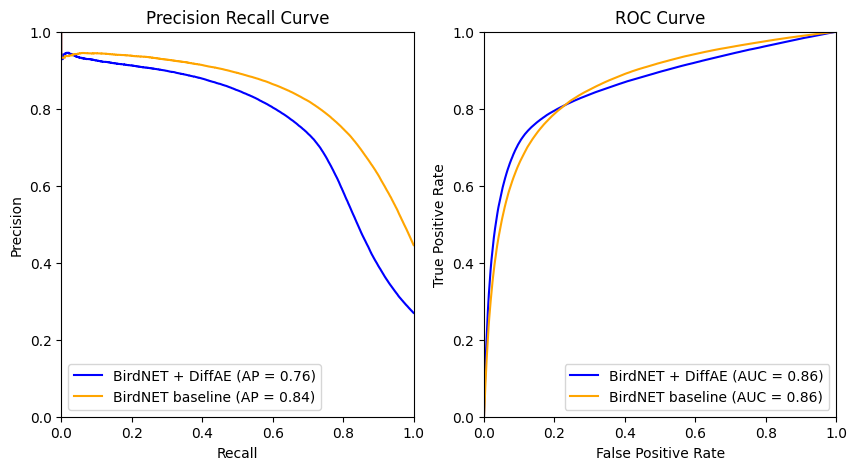

In [23]:
from sklearn.metrics import f1_score, recall_score, precision_score, PrecisionRecallDisplay, RocCurveDisplay
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for df in [diffae_output, birdnet_baseline]:
    if df is diffae_output:
        c = "blue"
        name = "BirdNET + DiffAE"
    else:
        c = "orange"
        name = "BirdNET baseline"
        
    correct = df.detected_sci_name == df.sci_name
    for display, axis in zip([PrecisionRecallDisplay, RocCurveDisplay], ax):
        display.from_predictions(correct, df.confidence, ax=axis, name=name, color=c)
        if display is PrecisionRecallDisplay:
            axis.set_title("Precision Recall Curve")
        else:
            axis.set_title("ROC Curve")

for axis in ax:
    text = axis.xaxis.label.get_text()
    text = text[:text.find("(")-1]
    axis.set_xlabel(text)
    
    text = axis.yaxis.label.get_text()
    text = text[:text.find("(")-1]
    axis.set_ylabel(text)

    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)

In [24]:
fig.savefig("/data/plots/diffae_curves.svg")